# 00.24 - QUEEN-NOQUEEN - NN Classification Stratified k-fold

## Prerequisites

- The dataset exists (if not, execute 00 - Dataset Initialisation)
- The dataset features have been populated (if not, execute 02 - Features Computation)


In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information                     
    say_my_name,                     # gets notebook name
    predestination                   # seeds various PRNGs for reproducibiliy
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

# Experiment name will be used to prefix potential outputs
EXP_NAME = say_my_name()

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

[2020-08-31/09:47:58.530|15.1%|77.5%|0.28GB] ------------------------------------------------------
[2020-08-31/09:47:58.530|00.0%|77.5%|0.28GB] DATASET NAME          : MAIN1000
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] SAMPLE RATE           : 22050
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] DURATION              : 1.0
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] OVERLAP               : 0.0
[2020-08-31/09:47:58.531|00.0%|77.5%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-08-31/09:47:58.532|00.0%|77.5%|0.28GB] ------------------------------------------------------


In [3]:
def simple_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_dim))
    model.add(keras.layers.Dense(2, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(2, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"]
    )    
    
    return model


def simple_model2(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(2, activation="selu", kernel_initializer="lecun_normal"))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(2, activation="selu", kernel_initializer="lecun_normal"))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer="nadam",
                  metrics=["accuracy"]
    )    
    
    return model

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

from audace.jupytools import predestination
from audace.audiodataset import serie_to_2D


# Experiment parameters
FEATURE_NAME = 'mfcc20'

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiment
# and shuffle it
iprint(">>>>> Query features and labels")
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=1)

# Get features and labels
X = serie_to_2D(df[FEATURE_NAME])
y = df['queen']
keras.backend.clear_session()

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=simple_model, input_dim=X[0].shape, epochs=10, batch_size=5, verbose=2)))

pipeline = Pipeline(estimators)

kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(pipeline, X, y, cv=kfold)

print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Using TensorFlow backend.


[2020-08-31/09:48:08.075|07.6%|76.0%|0.28GB] >>>>> Query features and labels
Train on 13764 samples
Epoch 1/10
13764/13764 - 3s - loss: 0.5565 - accuracy: 0.7274
Epoch 2/10
13764/13764 - 3s - loss: 0.4708 - accuracy: 0.7975
Epoch 3/10
13764/13764 - 3s - loss: 0.4419 - accuracy: 0.8205
Epoch 4/10
13764/13764 - 3s - loss: 0.4358 - accuracy: 0.8208
Epoch 5/10
13764/13764 - 3s - loss: 0.4271 - accuracy: 0.8238
Epoch 6/10
13764/13764 - 3s - loss: 0.4317 - accuracy: 0.8192
Epoch 7/10
13764/13764 - 3s - loss: 0.4146 - accuracy: 0.8346
Epoch 8/10
13764/13764 - 4s - loss: 0.4087 - accuracy: 0.8357
Epoch 9/10
13764/13764 - 4s - loss: 0.3944 - accuracy: 0.8366
Epoch 10/10
13764/13764 - 4s - loss: 0.4015 - accuracy: 0.8407
3441/3441 - 1s - loss: 0.1578 - accuracy: 0.9555
Train on 13764 samples
Epoch 1/10
13764/13764 - 5s - loss: 0.6039 - accuracy: 0.6669
Epoch 2/10
13764/13764 - 4s - loss: 0.4899 - accuracy: 0.7570
Epoch 3/10
13764/13764 - 4s - loss: 0.4795 - accuracy: 0.7648
Epoch 4/10
13764/1376

NameError: name 'history' is not defined

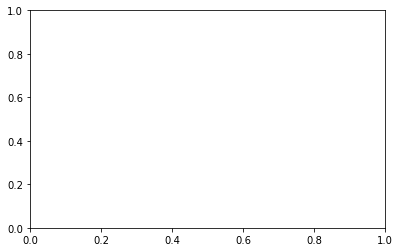

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()

In [5]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

NameError: name 'history' is not defined

In [6]:
from sklearn import metrics

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = model.predict(X_test)

# Display information about the classifier performance
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))

[2020-08-28/20:23:10.790|13.5%|82.1%|0.48GB] >>>>> Predict


NameError: name 'model' is not defined

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 7048      
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0

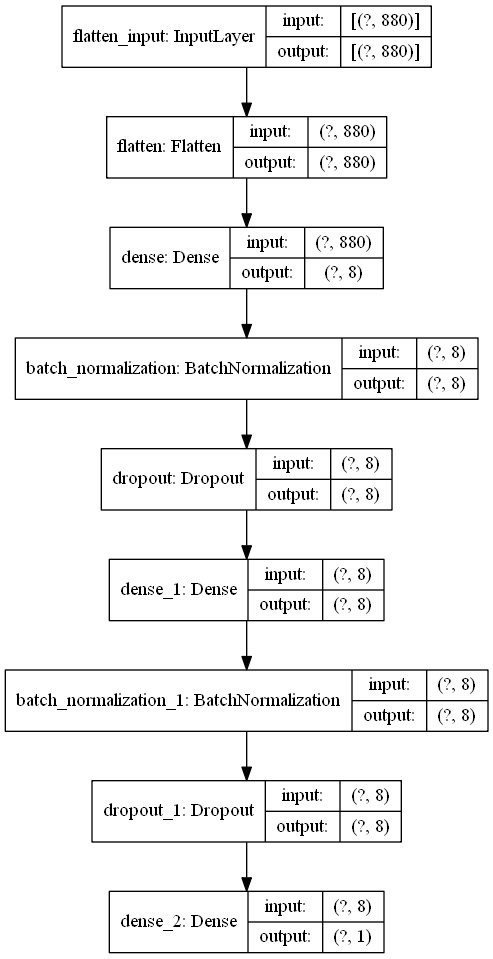

In [14]:
keras.utils.plot_model(model, "mlp.png", show_shapes=True)

In [18]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = F"Full Report - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}]"
clf_full_report(model, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

ValueError: Classification metrics can't handle a mix of binary and continuous targets